# Project 3 (Non Linear Programming)

**Group 25:**
1. Krittika Deshwal ()
2. Mayank Gupta (mg66426)
3. Rahull Ranji Borana (rb47374)
4. Sanyam Jain (sj33448)

**Problem Overview:** One of the most common problems in predictive analytics is variable selection for regression. 
Direct variable selection using optimization has long been dismissed by the statistics/analytics
community because of computational difficulties. This computational issue was part of the 
motivation for the development of LASSO and ridge regression. However, in the recent past 
there have been tremendous advancements in optimization software, specifically the ability to 
solve mixed integer quadratic programs (MIQP). This project will pose the variable selection 
problem for regression as an MIQP which you will solve using gurobi. You will compare the 
results you find to LASSO to see if the additional ‘shrinkage’ component of LASSO really is more 
beneficial than finding the ‘best’ set of variables to include in your regression.

**Objective**: One of the most common problems in predictive analytics is variable selection for regression. 
Direct variable selection using optimization has long been dismissed by the statistics/analytics
community because of computational difficulties. This computational issue was part of the 
motivation for the development of LASSO and ridge regression. However, in the recent past 
there have been tremendous advancements in optimization software, specifically the ability to 
solve mixed integer quadratic programs (MIQP). This project will pose the variable selection 
problem for regression as an MIQP which you will solve using gurobi. You will compare the 
results you find to LASSO to see if the additional ‘shrinkage’ component of LASSO really is more 
beneficial than finding the ‘best’ set of variables to include in your regression.

In [111]:
#importing required libraries
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

# standardizing the dataset
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Set a random seed so that we can get consistent shuffling for each run. Helpful for debuggin purposes.
np.random.seed(seed=42)

In [112]:
#time limit for gurobi model
grb_runtime = 100

## Data Preparation

In [113]:
train_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('test_data.csv')

#creating training df
train_df = train_data.copy()

#creating test df
test_df =test_data.copy()

# Storing raw training IVs and DV before prepocessing step 
X_train_og, y_train_og = train_data.drop(columns='y').to_numpy(), train_data['y'].to_numpy()
X_test_og, y_test_og = test_data.drop(columns='y').to_numpy(), train_data['y'].to_numpy()

train_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.53615,-1.53541,0.71889,-2.09915,-0.44284,-0.59898,-1.64257,0.20776,0.76064,0.57587,...,0.36187,1.79310,-0.63129,-0.06175,0.51105,0.48875,-0.61277,-0.47105,-1.13978,-0.26077
1,4.80834,-1.73461,0.55198,-2.14767,-1.55294,1.51491,-1.14397,0.73759,1.32124,-0.26168,...,-0.67798,-0.16568,0.06540,0.13716,1.25820,-0.12083,-1.56483,-0.24256,-0.00183,1.18745
2,-1.53043,0.09726,0.10763,-0.19422,0.33545,-0.40820,0.13326,0.70618,0.39497,-0.43712,...,1.10880,0.33379,0.28205,-1.08629,-0.11535,0.25786,-0.08884,-0.75123,1.45061,0.29059
3,-0.42824,-0.06770,0.55784,0.70085,-1.12138,1.72227,0.61353,0.70091,-0.41798,1.06975,...,0.69251,-0.35099,0.62456,0.43452,-0.36741,-1.14468,-0.13652,-0.55721,0.41630,0.48449
4,0.56669,0.48873,0.21148,0.56839,0.64684,0.16387,-0.00215,0.12514,0.49357,1.70545,...,-0.00060,1.07528,0.18228,-1.13846,0.10609,0.54464,-0.38349,-0.42577,2.66765,-0.05075


In [114]:
test_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.10795,-2.04701,0.26013,-0.78515,0.38458,-0.13761,-0.36457,-1.94125,-0.10818,-0.33922,...,-0.52219,1.86190,0.12451,1.14407,0.12818,-0.46797,-1.08560,0.65967,0.51472,0.80666
1,5.79627,-1.35433,-1.28988,1.32153,-0.09117,-1.02187,0.68678,0.08974,-0.39837,-0.26174,...,-0.50258,0.58448,0.68070,0.04679,0.56968,-1.09906,-0.06966,0.70927,-0.84867,0.99617
2,1.59865,0.50220,1.06289,1.46073,-1.50640,0.72166,0.52892,-0.69954,-0.27033,-2.54481,...,-0.12520,-1.29292,0.41179,-0.16421,-2.40740,-1.13250,0.45292,-0.94554,0.12652,-0.97207
3,2.53295,0.22238,-0.96075,-0.11376,1.93593,0.96939,-1.64140,0.02665,0.74714,-1.57178,...,-0.54692,-0.19252,0.60342,-0.27733,-1.45142,0.22077,0.47495,-0.16011,0.18805,-1.71123
4,0.59068,1.20995,1.58687,-0.69478,-0.22637,-0.15211,0.77236,-0.57374,-0.99249,-0.64666,...,-0.98224,-1.40778,0.09421,0.15996,-0.90161,-1.65312,0.39352,0.70254,0.55266,-0.77365


In [115]:
# shuffling training df and splitting Xs and Y
shuffled_ind = np.random.choice(train_df.index, size=len(train_df), replace=False)
shuffled_train_df = train_df.iloc[shuffled_ind]
X_train, y_train = shuffled_train_df.drop(columns='y').to_numpy(), shuffled_train_df['y'].to_numpy()

#splitting test df
X_test, y_test = test_df.drop(columns='y').to_numpy(), test_df['y'].to_numpy()

In [116]:
#variable for controlling no of training folds. Set to 10 for this problem
num_k_folds = 10

#splitting training df into 10 folds for performing cross-validation
split_ind = KFold(n_splits=num_k_folds).split(X_train)

k_folds_dict = {}
for i, ind in enumerate(split_ind):
    #temp dictionary 
    index_dict = {}
    # The training indices are in the first item of the tuple and the testing indices are in the second.
    index_dict['train_indices'] = ind[0]
    index_dict['test_indices'] = ind[1]
    k_folds_dict[i] = index_dict

# Sample of the dicitionary printed for the first fold
for i in range(num_k_folds):
    print(k_folds_dict[i])

{'train_indices': array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201,

## Choosing the optimal K values

In [117]:
#list of k values to try
k_options = np.arange(5,51,5)
print(k_options)

#initializing dataframe to store cross validation results
grb_df = pd.DataFrame(index=k_folds_dict.keys(),columns=k_options)
grb_df

[ 5 10 15 20 25 30 35 40 45 50]


,5,10,15,20,25,30,35,40,45,50
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
def predictions(x,betas):
    pred = []
   
    for i in range(x.shape[0]):
        pred_val = betas[0]
        for j in range(x.shape[1]):
            pred_val+= x[i,j]*betas[j+1]
            
        pred.append(pred_val)
    return pred

def sse(y,pred):
     return sum((y - pred)**2)

In [119]:
# Nested loops for k values and cross-validation folds
if os.path.exists('results.csv'):
    grb_df = pd.read_csv('results.csv')
else:
    for k in k_options:
        print(f"for k = {k}")
        for fold, indices_dict in k_folds_dict.items():
            # Select data for the current fold
            X_fold, y_fold = X_train[indices_dict['train_indices']], y_train[indices_dict['train_indices']]

            # Create a Gurobi model
            model = gp.Model()

            # variables
            beta = model.addMVar(X_train.shape[1] + 1, name="beta", lb=-np.inf)
            z = model.addMVar(X_train.shape[1], vtype=GRB.BINARY, name="z")

            # Objective function
            residuals = gp.quicksum((y_fold[j] - (beta[0] + gp.quicksum(beta[i + 1] * X_fold[j, i] for i in range(X_train.shape[1]))))*\
                (y_fold[j] - (beta[0] + gp.quicksum(beta[i + 1] * X_fold[j, i] for i in range(X_train.shape[1])))) for j in range(X_fold.shape[0]))
            model.setObjective(residuals, GRB.MINIMIZE)

            # Add constraints
            M = 100 # Set a large value for M
            M2 = -M

            bigMconspos = model.addConstrs((beta[i+1] <= M*z[i]) for i in range(50))
            bigMconsneg = model.addConstrs((beta[i+1] >= M2*z[i]) for i in range(50))

            z_con = model.addConstr(gp.quicksum(z[j] for j in range(X_train.shape[1])) == k)

            # Optimize the model
            model.Params.OutputFlag = 0
            model.Params.TimeLimit = grb_runtime
            model.optimize()
            
            #calculate residuals on validation set
            X_fold_val, y_fold_val = X_train[indices_dict['test_indices']], y_train[indices_dict['test_indices']]
            pred = predictions(X_fold_val,beta.x)
            error = sse(y_fold_val,pred)
            print(f"fold {fold} SSE on val set is = {error}")

            # Store the results in the DataFrame
            grb_df.at[fold, k] = error
            
            #Save the results to csv file
            grb_df.to_csv('results.csv',index=False)


In [120]:
grb_df

,5,10,15,20,25,30,35,40,45,50
0,121.08483,83.22601,84.98515,82.43595,92.91026,95.66110,97.65884,99.99508,96.91679,97.57031
1,76.27096,68.72295,85.44507,91.70347,102.49541,98.26731,96.42208,96.91586,100.55214,101.13772
2,76.40846,62.50184,70.91066,83.65107,88.56933,73.46238,78.72707,80.83133,79.92967,79.96562
3,72.64028,62.72359,71.70770,71.71293,70.69936,72.59391,76.85514,77.86652,78.59641,78.33711
4,118.95958,82.00438,83.84794,80.40048,80.64813,86.74073,90.89855,87.67083,86.81163,86.93229
5,82.97925,61.88108,65.54801,59.53692,75.45312,65.59325,61.14406,66.13959,67.22787,67.36372
6,76.18434,65.08857,69.81931,70.62222,69.18039,70.47346,67.89549,71.89055,75.20079,75.06871
7,60.29282,48.66334,59.89032,54.19826,56.43211,55.66685,54.96695,60.79733,62.11971,63.55508
8,133.75785,93.39369,99.85986,105.95280,98.82562,105.08918,104.69604,103.73865,104.83067,104.08194
9,95.53616,75.76057,87.45220,89.38065,86.02599,84.18368,88.06178,84.99322,86.84317,86.44153


In [121]:
# We aggregate the results of each lambda across all folds by averaging each folds SSE to get an "Avg SSE"
avg_sse = grb_df.mean()
pd.DataFrame(avg_sse,columns=['Avg SSE'])

,Avg SSE
5,91.41145
10,70.39660
15,77.94662
20,78.95948
25,82.12397
30,80.77318
35,81.73260
40,83.08390
45,83.90288
50,84.04540


Text(0, 0.5, 'Avg SSE Across All Folds')

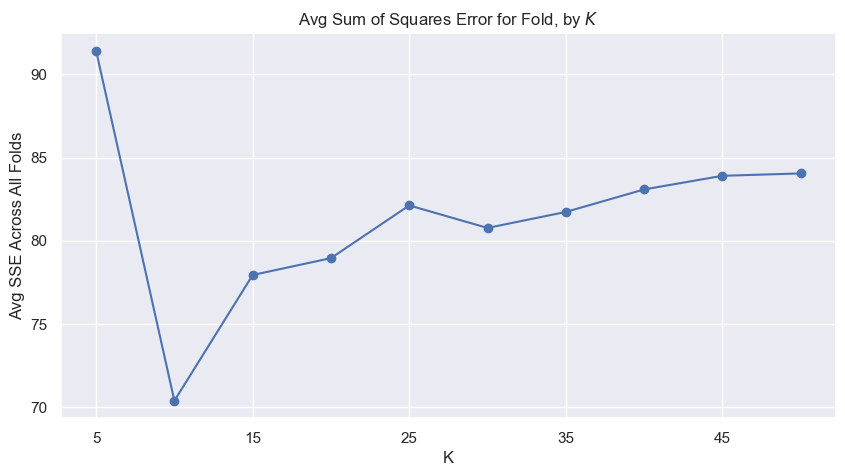

In [122]:
avg_sse.plot(figsize=(10,5),marker='o')
plt.title('Avg Sum of Squares Error for Fold, by $K$')
plt.xlabel('K')
plt.ylabel('Avg SSE Across All Folds')

In [123]:
# Store the best K for later use
best_k = int(avg_sse.sort_values().index[0])
print(f'The best lambda = {best_k}')

The best lambda = 10


In [124]:
# Creating a master df here to store the evaluation metrics for both Gurobi optimization and Lasso. That will make for easy comparison later.
best_results_train = pd.DataFrame(columns=['SSE','MSE','R_Squared'])
best_results_test = pd.DataFrame(columns=['SSE','MSE','R_Squared'])


In [125]:
# Create and fit the model with the best K
# Create a Gurobi model
model = gp.Model()

# variables
beta = model.addMVar(X_train.shape[1] + 1, name="beta", lb=-np.inf)
z = model.addMVar(X_train.shape[1], vtype=GRB.BINARY, name="z")

# Objective function
residuals = gp.quicksum((y_train[j] - (beta[0] + gp.quicksum(beta[i + 1] * X_train[j, i] for i in range(X_train.shape[1]))))*(y_train[j] - (beta[0] + gp.quicksum(beta[i + 1] * X_train[j, i] for i in range(X_train.shape[1])))) for j in range(X_train.shape[0]))
model.setObjective(residuals, GRB.MINIMIZE)

# Add constraints
M = 100 # Set a large value for M
M2 = -M

bigMconspos = model.addConstrs((beta[i+1] <= M*z[i]) for i in range(50))
bigMconsneg = model.addConstrs((beta[i+1] >= M2*z[i]) for i in range(50))

z_con = model.addConstr(gp.quicksum(z[j] for j in range(X_train.shape[1])) == best_k)

# Optimize the model
model.Params.OutputFlag = 0
model.Params.TimeLimit = grb_runtime
model.optimize()

best_betas = beta.x

best_betas

array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

In [126]:
#Training Error Gurobi
gurobi_predictions_train = predictions(X_train,best_betas)

gurobi_sse_train = sse(y_train,gurobi_predictions_train)
gurobi_mse_train = mean_squared_error(y_train,gurobi_predictions_train)
gurobi_r_squared_train = r2_score(y_train,gurobi_predictions_train)

best_results_train.loc['Gurobi_Method_Metrics'] = [gurobi_sse_train,gurobi_mse_train,gurobi_r_squared_train]
best_results_train

,SSE,MSE,R_Squared
Gurobi_Method_Metrics,597.99632,2.39199,0.87834


Optimal K Value for MIQP : 10 <br>
SSE on Train Data for MIQP : 597.99 <br>
SSE on Test Data for MIQP : 116.82 <br>

In [127]:

# Predict on hold out set and put the metrics into the best results df
gurobi_predictions_test = predictions(X_test,best_betas)

gurobi_sse_test = sse(y_test,gurobi_predictions_test)
gurobi_mse_test = mean_squared_error(y_test,gurobi_predictions_test)
gurobi_r_squared_test = r2_score(y_test,gurobi_predictions_test)

best_results_test.loc['Gurobi_Method_Metrics'] = [gurobi_sse_test,gurobi_mse_test,gurobi_r_squared_test]
best_results_test

,SSE,MSE,R_Squared
Gurobi_Method_Metrics,116.82720,2.33654,0.85867


## Lasso

In [137]:
from sklearn.linear_model import Lasso, LassoCV

X_train=train_data.drop(columns='y')
y_train= train_data['y']

X_test = test_data.drop(columns = 'y')
y_test = test_data['y']

std_trans = StandardScaler()
std_trans.fit(X_train)

#transforming on X_train and X_test
X_train_std = std_trans.transform(X_train)
X_test_std = std_trans.transform(X_test)

#using LassoCv to get the best lambda(regularization penalty) and training the data with this value
lassocv = LassoCV(alphas = None, cv = 10)
lassocv.fit(X_train_std, y_train)



#print best lambda value
print('Best Value of lambda:',lassocv.alpha_ )



Best Value of lambda: 0.08471942409934509


In [138]:
best_beta_lasso = lasso.coef_
best_beta_lasso

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.16054765,  0.        ,
       -0.05964031, -0.        , -0.        , -0.        , -0.41912484,
       -0.19325408,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.19517759, -1.36388738,  0.7425965 , -0.        ,
       -1.30481574, -0.        ,  0.        ,  0.05798283,  0.        ,
       -0.        ,  0.        , -0.09737839,  0.28341629,  0.        ,
        0.        ,  0.        ,  0.        , -0.23157873,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.03078191,  1.56362172,
       -0.02160033,  0.69992447, -0.09289745,  0.        ,  0.        ])

In [140]:
#Training error Lasso
lasso_predictions_train = lassocv.predict(X_train_std)
lasso_sse_train = sse(y_train,lasso_predictions_train)
lasso_mse_train = mean_squared_error(y_train,lasso_predictions_train)
lasso_r_squared_train = r2_score(y_train,lasso_predictions_train)

best_results_train.loc['Lasso_Metrics'] = [lasso_sse_train, lasso_mse_train, lasso_r_squared_train]

In [144]:
# Predict on hold out set and put the metrics into the best results df
lasso_predictions_test = lassocv.predict(X_test_std)
lasso_sse_test = sse(y_test,lasso_predictions_test)
lasso_mse_test = mean_squared_error(y_test,lasso_predictions_test)
lasso_r_squared_test = r2_score(y_test,lasso_predictions_test)

best_results_test.loc['Lasso_Metrics'] = [lasso_sse_test, lasso_mse_test, lasso_r_squared_test]

## Compare (gurobi vs Lasso)

In [142]:
best_results_train

,SSE,MSE,R_Squared
Gurobi_Method_Metrics,597.99632,2.39199,0.87834
Lasso_Metrics,596.61112,2.38644,0.87862


In [145]:
best_results_test

,SSE,MSE,R_Squared
Gurobi_Method_Metrics,116.82720,2.33654,0.85867
Lasso_Metrics,117.83332,2.35667,0.85745


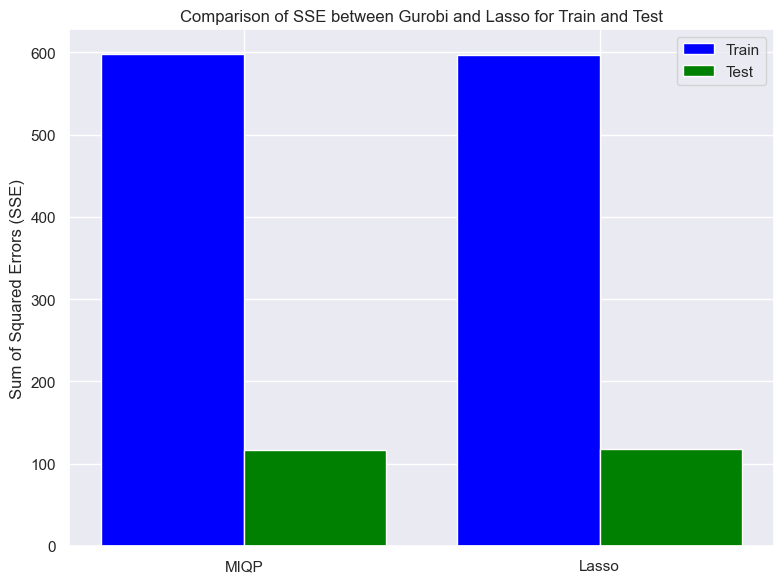

In [161]:
# Set up bar positions
labels = ["MIQP", "Lasso"]
y = np.arange(len(labels))

# Plotting the bars
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.4

bars_gurobi_train = ax.bar(y, [sse_values_train_gurobi[0], sse_values_train_lasso[0]], bar_width, label='Train', color='blue')
bars_gurobi_test = ax.bar(y + bar_width, [sse_values_test_gurobi[0], sse_values_test_lasso[0]], bar_width, label='Test', color='green')

# Adding labels, title, and legend
ax.set_ylabel('Sum of Squared Errors (SSE)')
ax.set_title('Comparison of SSE between Gurobi and Lasso for Train and Test')
ax.set_xticks(y + bar_width / 2)
ax.set_xticklabels(labels)  # Add this line to set x-axis labels
ax.legend(["Train", "Test"])

# Display the bar graph
plt.tight_layout()
plt.show()


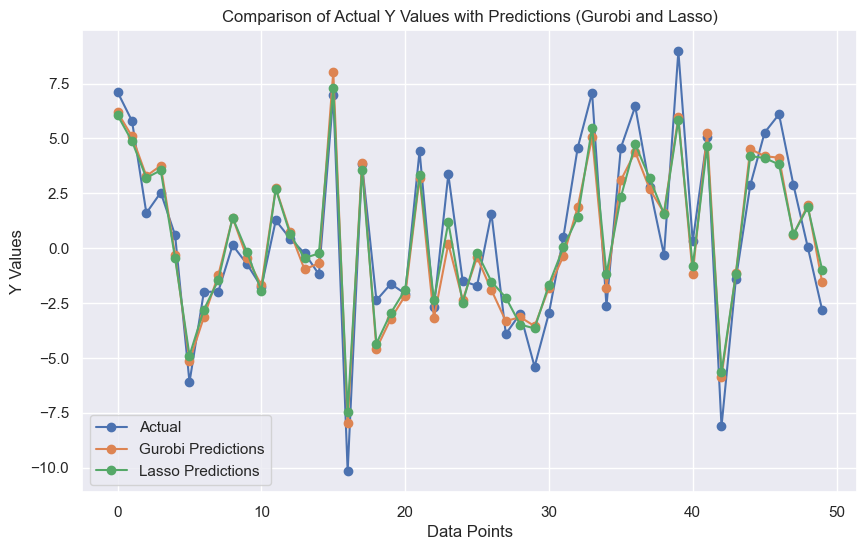

In [160]:
# Plotting the line graph
plt.figure(figsize=(10, 6))

# Plotting actual y values
plt.plot(y_test, label='Actual', marker='o')

# Plotting Gurobi predictions
plt.plot(gurobi_predictions_test, label='Gurobi Predictions', marker='o')

# Plotting Lasso predictions
plt.plot(lasso_predictions_test, label='Lasso Predictions', marker='o')

# Adding labels, title, and legend
plt.xlabel('Data Points')
plt.ylabel('Y Values')
plt.title('Comparison of Actual Y Values with Predictions (Gurobi and Lasso)')
plt.legend()

# Display the line graph
plt.grid(True)
plt.show()


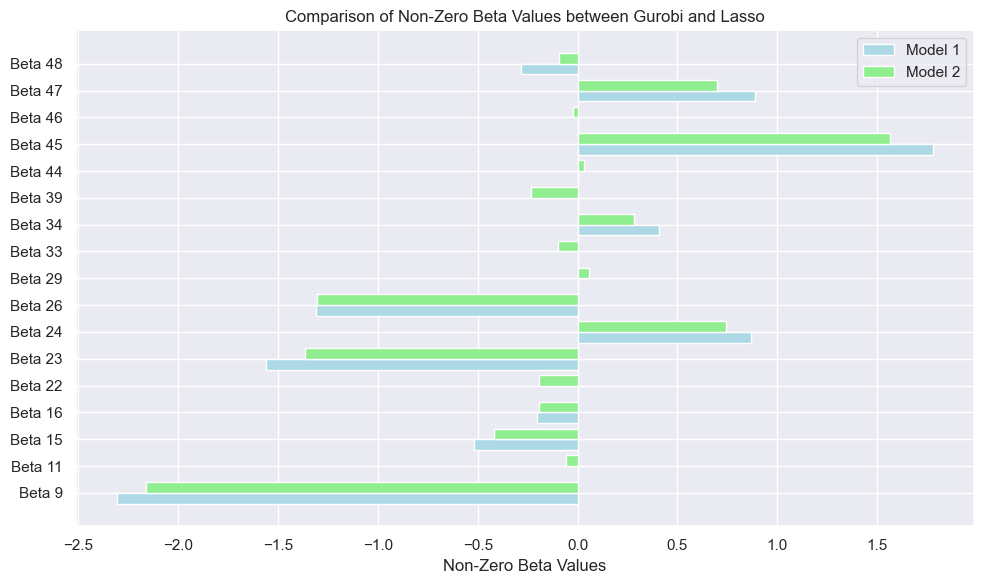

In [79]:
#Beta Comparison
best_betas_plot = best_betas[1:]
# Get non-zero beta indices for both models
non_zero_indices_model1 = np.where(best_betas_plot != 0)[0]
non_zero_indices_model2 = np.where(best_beta_lasso != 0)[0]

# Combine non-zero indices from both models
combined_non_zero_indices = np.union1d(non_zero_indices_model1, non_zero_indices_model2)

# Generate labels for each non-zero beta
labels = [f'Beta {i+1}' for i in combined_non_zero_indices]

# Set up bar positions
y = np.arange(len(labels))

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4

bars1 = ax.barh(y, best_betas_plot[combined_non_zero_indices], bar_width, label='Model 1', color='lightblue')
bars2 = ax.barh(y + bar_width, best_beta_lasso[combined_non_zero_indices], bar_width, label='Model 2', color='lightgreen')

# Adding labels, title, and legend
ax.set_xlabel('Non-Zero Beta Values')
ax.set_title('Comparison of Non-Zero Beta Values between Gurobi and Lasso')
ax.set_yticks(y + bar_width / 2)
ax.set_yticklabels(labels)
ax.legend()

# Display the bar graph
plt.tight_layout()
plt.show()
